# Seizure Bandpower

Patient chb_01 has 6 seizures recorded in this dataset. By observing 10s snapshots before, during and after the seizure, we notice a change in the pattern of dominant spectral band.

# Patient 1

We will explore how many seizures patient 1 have and their duration. We also observe the visual differences in the signal.

In [2]:
import os
import re
import mne
import yasa
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# %matplotlib osx

In [4]:
# clean channel names
def clean_channels(raw):
    replace_dict = {}
    drop_list = []
    # for the channel names in the data...
    for channel_name in raw.info['ch_names']:
        # get the name to change too
        name_change = re.findall('\w+',channel_name)[0].title()
        # check if it is already in the change list
        if name_change in list(replace_dict.values()):
            drop_list.append(channel_name)
        else:
            # if its not already there get the origional name and what we want to 
            # change it to
            replace_dict[channel_name] = name_change

    # drop the ones that would be repeats
    raw.drop_channels(drop_list)
    # rename the channels
    raw.rename_channels(replace_dict)
    # set the standard montage
    montage =  mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, match_case=False)

In [5]:
def parse_summary(fpath):
    file_metadata = []
    with open(fpath) as f:
        content_str = f.read()
        regex = re.compile(r'^\Z|\*+') # match empty string or literal asterisks
        filtered = [x for x in content_str.split('\n') if not regex.search(x)]
        regex = re.compile('Channel \d+') # match channel numbers
        channels = [x.split(':')[-1].strip() for x in filtered if regex.search(x)]
        regex = re.compile('Data Sampling Rate:')
        fs = int([x.split(':')[-1].strip() for x in filtered if regex.search(x)][0].split(' ')[0])
        regex = re.compile('^(?!Channel|Data).') # match file names
        file_metas = [x for x in filtered if regex.findall(x)]
        file_meta = {}
        for x in file_metas:
            k, v = x.partition(':')[::2]

            if k == 'Seizure Start Time':
                file_meta['Seizure Start Time'] = v
            if k == 'Seizure End Time':
                file_meta['Seizure End Time'] = v
                tup_meta = {'File Name': file_meta['File Name'], 
                                'File Start Time': file_meta['File Start Time'], 
                                'File End Time': file_meta['File End Time'],
                                'Number of Seizures in File': file_meta['Number of Seizures in File'],
                                'Seizure Start Time': file_meta['Seizure Start Time'],
                                'Seizure End Time': file_meta['Seizure End Time']
                               }
                file_metadata.append(tup_meta)

            if k == 'File Name':
                file_meta['File Name'] = v.strip()
            if k == 'File Start Time':
                file_meta['File Start Time'] = v.strip()
            if k == 'File End Time':
                file_meta['File End Time'] = v.strip()
            if k == 'Number of Seizures in File':
                if int(v) == 0:
                    if 'Seizure End Time' in file_meta:
                        del file_meta['Seizure End Time']
                    if 'Seizure Start Time' in file_meta:
                        del file_meta['Seizure Start Time']
                    file_meta['Number of Seizures in File'] = 0
                    tup_meta = {'File Name': file_meta['File Name'], 
                                'File Start Time': file_meta['File Start Time'], 
                                'File End Time': file_meta['File End Time'],
                                'Number of Seizures in File': file_meta['Number of Seizures in File']
                               }
                    file_metadata.append(tup_meta)
                if int(v) > 0:
                    file_meta['Number of Seizures in File'] = int(v.strip())

    return file_metadata

In [6]:
root = '/Volumes/My Passport/AI_Research/data/physionet.org/files/chbmit/1.0.0/chb01/'
dict_files = parse_summary(os.path.join(root, os.listdir(root)[0])) # load chb01-summary.txt
len(dict_files)

42

In [31]:
print('Index | Filename | Contents')
print('---')
raw_clips = []
i = 0
for dict_file in dict_files:
    if dict_file['File Name'].endswith('edf'):
        fpath = os.path.join(root, dict_file['File Name'])
        raw = mne.io.read_raw_edf(input_fname=fpath, preload=False, verbose='Error')
        print(i, dict_file['File Name'], ' ', end='')
        if dict_file['Number of Seizures in File'] > 0:
            start_secs = int(dict_file['Seizure Start Time'].split(' ')[-2])
            end_secs = int(dict_file['Seizure End Time'].split(' ')[-2])
            annot = mne.Annotations(onset=[0, start_secs, end_secs],  # in seconds
                           duration=[start_secs,  (end_secs - start_secs), ((60*59)-end_secs)],  # in seconds, too
                           description=['Background', 'Seizure', 'Background'])
            raw.set_annotations(annot)
            print(annot)
        else:
            annot = mne.Annotations(onset=[0], duration=[3600], description=['Background'])
            raw.set_annotations(annot)
            print(annot)
        clean_channels(raw)
        raw_clips.append(raw)
    i = i + 1
len(raw_clips)

Index | Filename | Contents
---
0 chb01_01.edf  <Annotations | 1 segment: Background (1)>
1 chb01_02.edf  <Annotations | 1 segment: Background (1)>
2 chb01_03.edf  <Annotations | 3 segments: Background (2), Seizure (1)>
3 chb01_04.edf  <Annotations | 3 segments: Background (2), Seizure (1)>
4 chb01_05.edf  <Annotations | 1 segment: Background (1)>
5 chb01_06.edf  <Annotations | 1 segment: Background (1)>
6 chb01_07.edf  <Annotations | 1 segment: Background (1)>
7 chb01_08.edf  <Annotations | 1 segment: Background (1)>
8 chb01_09.edf  <Annotations | 1 segment: Background (1)>
9 chb01_10.edf  <Annotations | 1 segment: Background (1)>
10 chb01_11.edf  <Annotations | 1 segment: Background (1)>
11 chb01_12.edf  <Annotations | 1 segment: Background (1)>
12 chb01_13.edf  <Annotations | 1 segment: Background (1)>
13 chb01_14.edf  <Annotations | 1 segment: Background (1)>
14 chb01_15.edf  <Annotations | 3 segments: Background (2), Seizure (1)>
15 chb01_16.edf  <Annotations | 3 segments: Backgro

42

In [37]:
selected_bands = [(1, 4, 'Delta'),
         (4, 8, 'Theta'),
         (8, 12, 'Alpha'),
         (12, 30, 'Beta'),
         (30, 127,'Gamma')] # Nyquest frequency is 128 Hz for 256 Hz samping rate, thus we can only see up to 127 Hz limit.

In [16]:
# plot parameters
plot_kwargs = {
    'scalings': dict(eeg=25e-5), # manually set scale to 500 uV for 'best' representation
    'show_scrollbars': True,
    'show': True
}

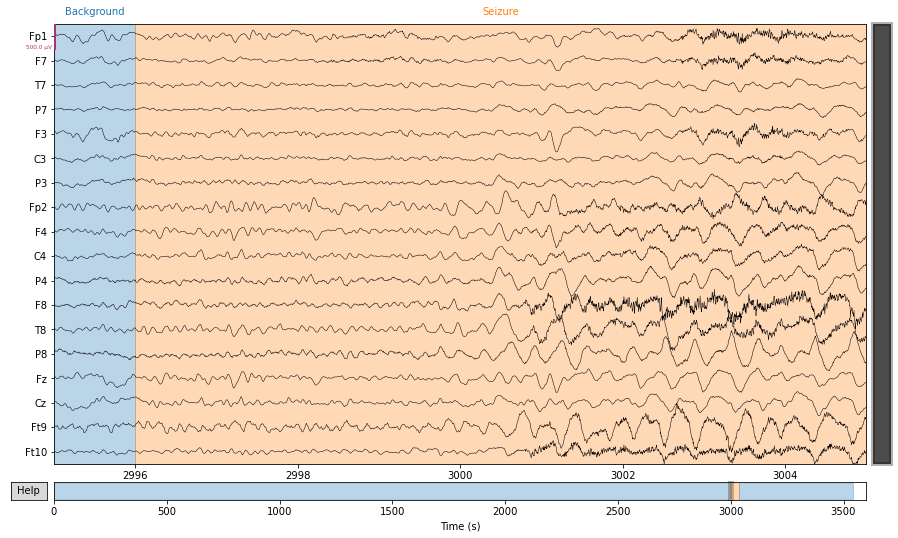

In [17]:
# plot all channels - time domain
raw_clips[2].plot(start=2995, **plot_kwargs);

## Bandpower Shifts

First 10s of clip.

0 10


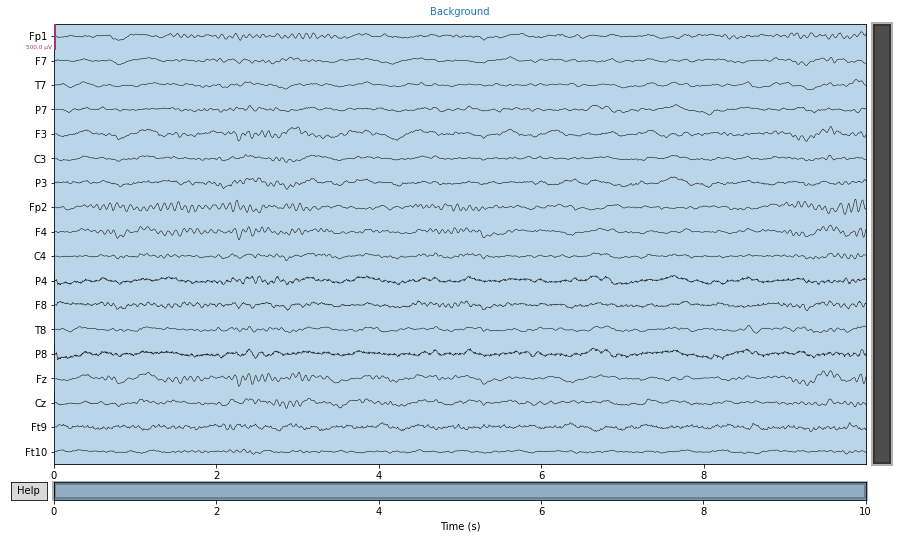

(18, 2561)


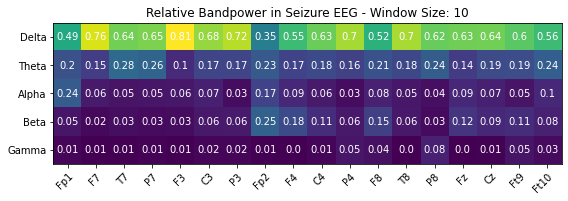

In [52]:
# crop 10s period from the start of the clip
start, end = 0, 10
print(start, end)
raw = raw_clips[2].copy()
raw.crop(tmin=start, tmax=end, include_tmax=True)
raw.plot(**plot_kwargs);

# determine the dominant brain wave in all channels from seizure period
window_size = 10
sampling_freq = raw.info['sfreq']
eeg_channel_indices = mne.pick_types(raw.info, meg=False, eeg=True)
eeg_data, times = raw[eeg_channel_indices, :]
print(eeg_data.shape)
df = yasa.bandpower(eeg_data, sampling_freq, win_sec=window_size, bands=selected_bands, bandpass=True,
                    ch_names=raw.info.ch_names, relative=True)

# visualise with a heatmap
channels = list(df.index)
bands = list(df.iloc[:,0:5].columns)
relative_bandpower = df.iloc[:,0:5].to_numpy()

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(relative_bandpower.T)
ax.set_yticks(np.arange(len(bands)))
ax.set_xticks(np.arange(len(channels)))
ax.set_yticklabels(bands)
ax.set_xticklabels(channels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# loop over data dimensions and create text annotations
for i in range(len(bands)):
    for j in range(len(channels)):
        text = ax.text(j, i, np.around(relative_bandpower[j, i], 2), ha='center', va='center', color='w')

ax.set_title(f'Relative Bandpower in Seizure EEG - Window Size: {window_size}')
fig.tight_layout()
plt.show()

2986 2996


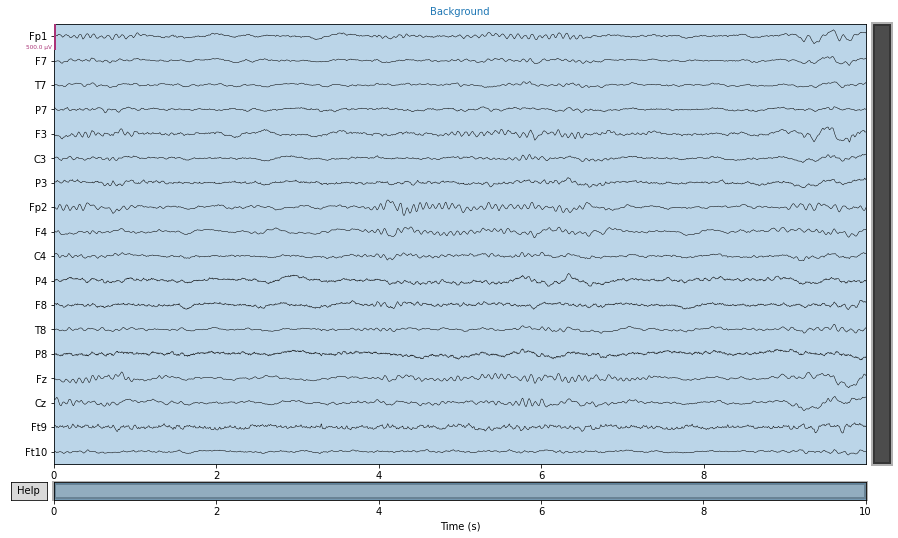

In [34]:
# crop 10s period ending where seizure begins (2996s)
start, end = (2996-10), 2996
print(start, end)
raw = raw_clips[2].copy()
raw.crop(tmin=start, tmax=end, include_tmax=True)
raw.plot(**plot_kwargs);

(18, 2561)


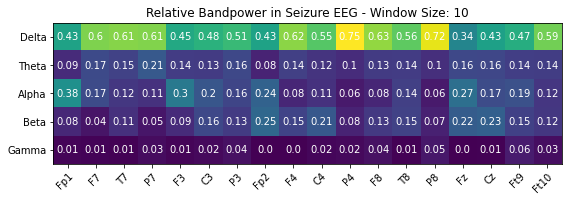

In [42]:
# determine the dominant brain wave in all channels from seizure period
window_size = 10
sampling_freq = raw.info['sfreq']
eeg_channel_indices = mne.pick_types(raw.info, meg=False, eeg=True)
eeg_data, times = raw[eeg_channel_indices, :]
print(eeg_data.shape)
df = yasa.bandpower(eeg_data, sampling_freq, win_sec=window_size, bands=selected_bands, bandpass=True,
                    ch_names=raw.info.ch_names, relative=True)

# visualise with a heatmap
channels = list(df.index)
bands = list(df.iloc[:,0:5].columns)
relative_bandpower = df.iloc[:,0:5].to_numpy()

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(relative_bandpower.T)
ax.set_yticks(np.arange(len(bands)))
ax.set_xticks(np.arange(len(channels)))
ax.set_yticklabels(bands)
ax.set_xticklabels(channels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# loop over data dimensions and create text annotations
for i in range(len(bands)):
    for j in range(len(channels)):
        text = ax.text(j, i, np.around(relative_bandpower[j, i], 2), ha='center', va='center', color='w')

ax.set_title(f'Relative Bandpower in Seizure EEG - Window Size: {window_size}')
fig.tight_layout()
plt.show()

2996 3006


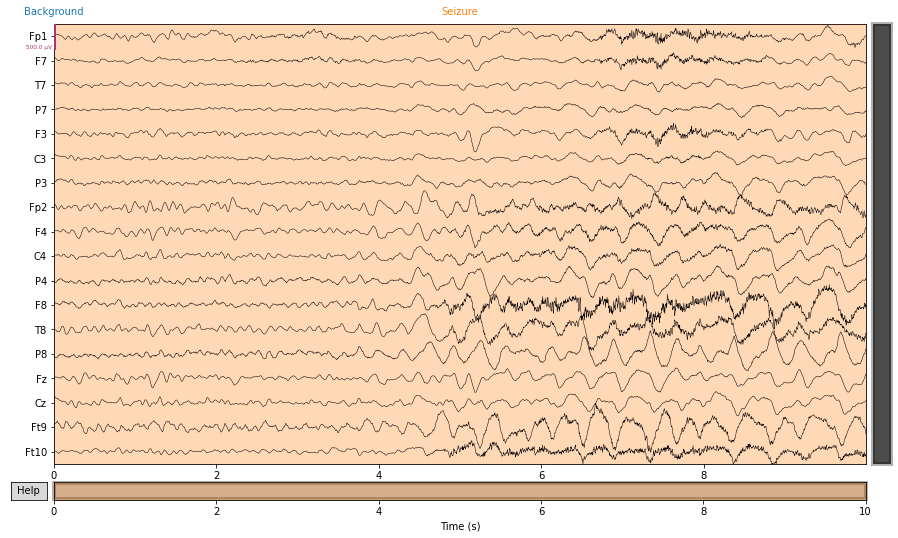

In [44]:
# crop 10s period starting where seizure begins (2996s)
start, end = 2996, 2996+10
print(start, end)
raw = raw_clips[2].copy()
raw.crop(tmin=start, tmax=end, include_tmax=True)
raw.plot(**plot_kwargs);

(18, 2561)


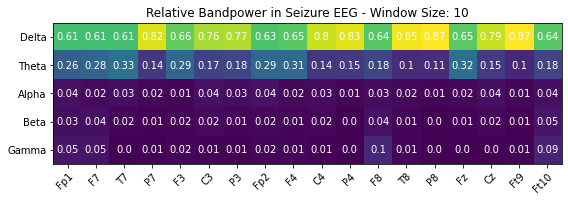

In [45]:
# determine the dominant brain wave in all channels from seizure period
window_size = 10
sampling_freq = raw.info['sfreq']
eeg_channel_indices = mne.pick_types(raw.info, meg=False, eeg=True)
eeg_data, times = raw[eeg_channel_indices, :]
print(eeg_data.shape)
df = yasa.bandpower(eeg_data, sampling_freq, win_sec=window_size, bands=selected_bands, bandpass=True,
                    ch_names=raw.info.ch_names, relative=True)

# visualise with a heatmap
channels = list(df.index)
bands = list(df.iloc[:,0:5].columns)
relative_bandpower = df.iloc[:,0:5].to_numpy()

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(relative_bandpower.T)
ax.set_yticks(np.arange(len(bands)))
ax.set_xticks(np.arange(len(channels)))
ax.set_yticklabels(bands)
ax.set_xticklabels(channels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# loop over data dimensions and create text annotations
for i in range(len(bands)):
    for j in range(len(channels)):
        text = ax.text(j, i, np.around(relative_bandpower[j, i], 2), ha='center', va='center', color='w')

ax.set_title(f'Relative Bandpower in Seizure EEG - Window Size: {window_size}')
fig.tight_layout()
plt.show()

3006 3016


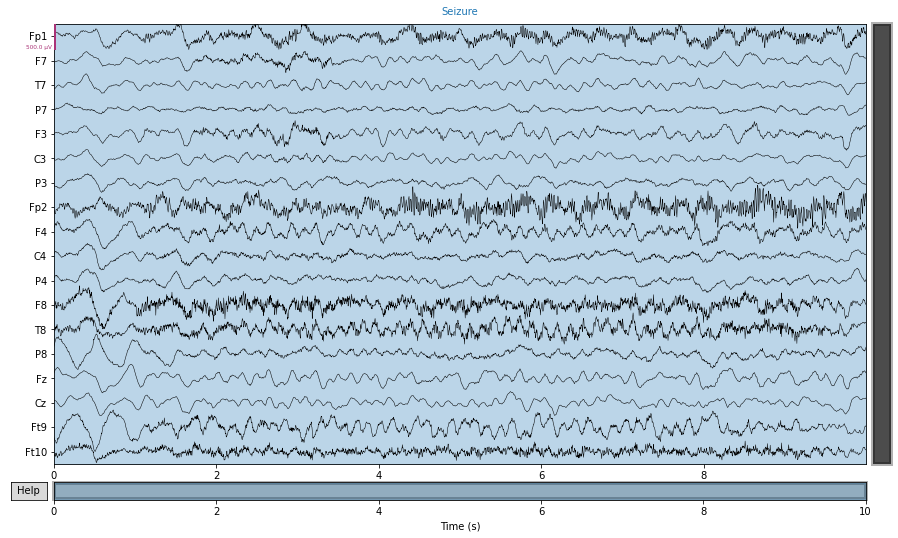

In [46]:
# crop 10s period 10 after seizure starts
start, end = 2996+10, 2996+20
print(start, end)
raw = raw_clips[2].copy()
raw.crop(tmin=start, tmax=end, include_tmax=True)
raw.plot(**plot_kwargs);

(18, 2561)


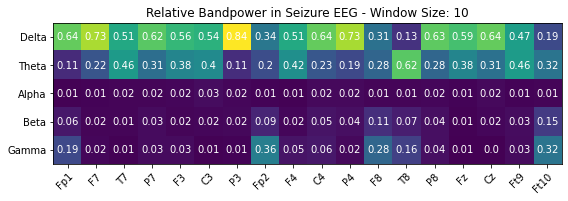

In [47]:
# determine the dominant brain wave in all channels from seizure period
window_size = 10
sampling_freq = raw.info['sfreq']
eeg_channel_indices = mne.pick_types(raw.info, meg=False, eeg=True)
eeg_data, times = raw[eeg_channel_indices, :]
print(eeg_data.shape)
df = yasa.bandpower(eeg_data, sampling_freq, win_sec=window_size, bands=selected_bands, bandpass=True,
                    ch_names=raw.info.ch_names, relative=True)

# visualise with a heatmap
channels = list(df.index)
bands = list(df.iloc[:,0:5].columns)
relative_bandpower = df.iloc[:,0:5].to_numpy()

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(relative_bandpower.T)
ax.set_yticks(np.arange(len(bands)))
ax.set_xticks(np.arange(len(channels)))
ax.set_yticklabels(bands)
ax.set_xticklabels(channels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# loop over data dimensions and create text annotations
for i in range(len(bands)):
    for j in range(len(channels)):
        text = ax.text(j, i, np.around(relative_bandpower[j, i], 2), ha='center', va='center', color='w')

ax.set_title(f'Relative Bandpower in Seizure EEG - Window Size: {window_size}')
fig.tight_layout()
plt.show()

3026 3036


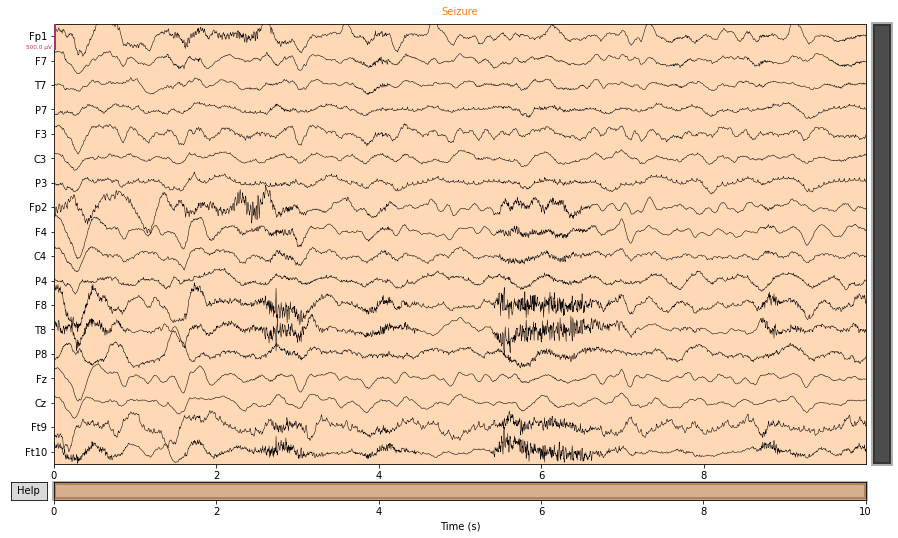

In [48]:
# crop 10s period before seizure ends
start, end = 3036-10, 3036
print(start, end)
raw = raw_clips[2].copy()
raw.crop(tmin=start, tmax=end, include_tmax=True)
raw.plot(**plot_kwargs);

(18, 2561)


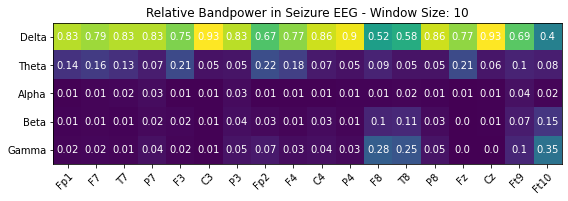

In [49]:
# determine the dominant brain wave in all channels from seizure period
window_size = 10
sampling_freq = raw.info['sfreq']
eeg_channel_indices = mne.pick_types(raw.info, meg=False, eeg=True)
eeg_data, times = raw[eeg_channel_indices, :]
print(eeg_data.shape)
df = yasa.bandpower(eeg_data, sampling_freq, win_sec=window_size, bands=selected_bands, bandpass=True,
                    ch_names=raw.info.ch_names, relative=True)

# visualise with a heatmap
channels = list(df.index)
bands = list(df.iloc[:,0:5].columns)
relative_bandpower = df.iloc[:,0:5].to_numpy()

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(relative_bandpower.T)
ax.set_yticks(np.arange(len(bands)))
ax.set_xticks(np.arange(len(channels)))
ax.set_yticklabels(bands)
ax.set_xticklabels(channels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# loop over data dimensions and create text annotations
for i in range(len(bands)):
    for j in range(len(channels)):
        text = ax.text(j, i, np.around(relative_bandpower[j, i], 2), ha='center', va='center', color='w')

ax.set_title(f'Relative Bandpower in Seizure EEG - Window Size: {window_size}')
fig.tight_layout()
plt.show()

3036 3046


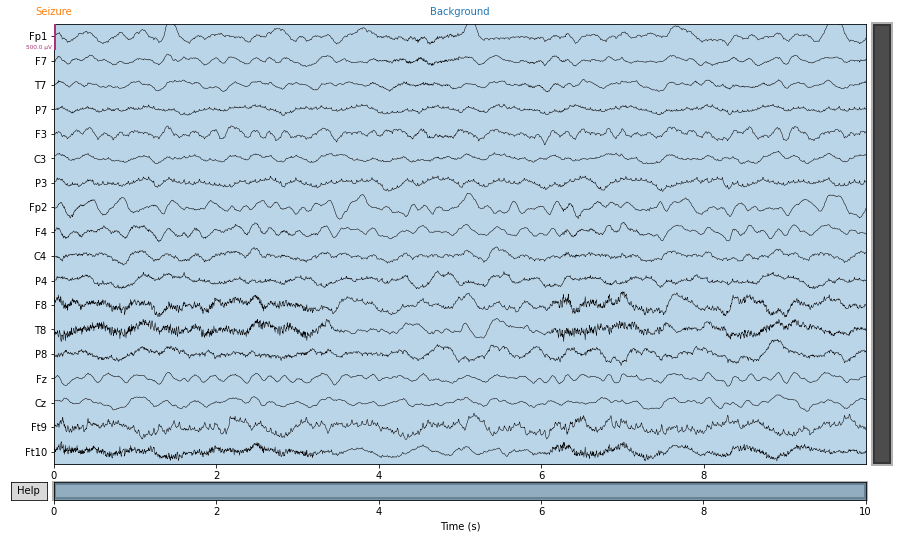

In [50]:
# crop 10s period after seizure ends
start, end = 3036, 3036+10
print(start, end)
raw = raw_clips[2].copy()
raw.crop(tmin=start, tmax=end, include_tmax=True)
raw.plot(**plot_kwargs);

(18, 2561)


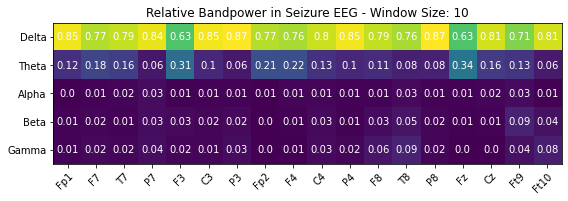

In [51]:
# determine the dominant brain wave in all channels from seizure period
window_size = 10
sampling_freq = raw.info['sfreq']
eeg_channel_indices = mne.pick_types(raw.info, meg=False, eeg=True)
eeg_data, times = raw[eeg_channel_indices, :]
print(eeg_data.shape)
df = yasa.bandpower(eeg_data, sampling_freq, win_sec=window_size, bands=selected_bands, bandpass=True,
                    ch_names=raw.info.ch_names, relative=True)

# visualise with a heatmap
channels = list(df.index)
bands = list(df.iloc[:,0:5].columns)
relative_bandpower = df.iloc[:,0:5].to_numpy()

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(relative_bandpower.T)
ax.set_yticks(np.arange(len(bands)))
ax.set_xticks(np.arange(len(channels)))
ax.set_yticklabels(bands)
ax.set_xticklabels(channels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# loop over data dimensions and create text annotations
for i in range(len(bands)):
    for j in range(len(channels)):
        text = ax.text(j, i, np.around(relative_bandpower[j, i], 2), ha='center', va='center', color='w')

ax.set_title(f'Relative Bandpower in Seizure EEG - Window Size: {window_size}')
fig.tight_layout()
plt.show()

Last 10s of clip.

3589 3599


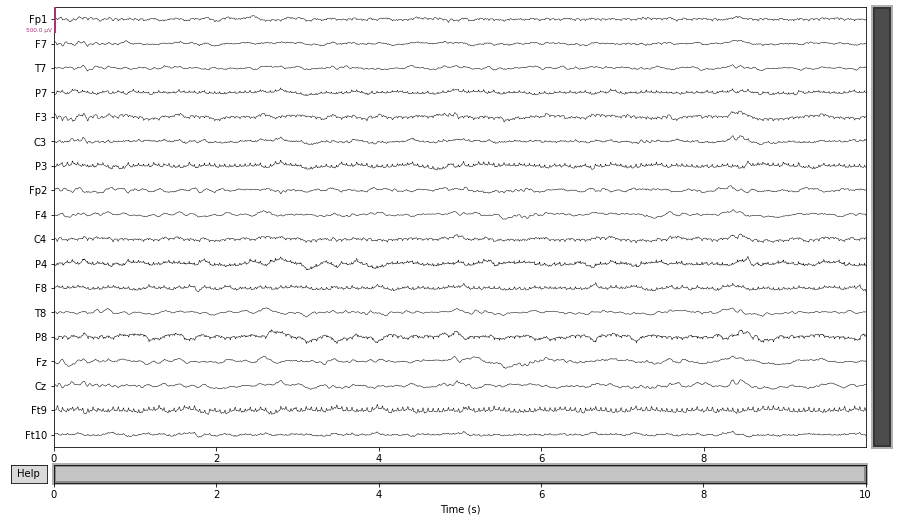

(18, 2561)


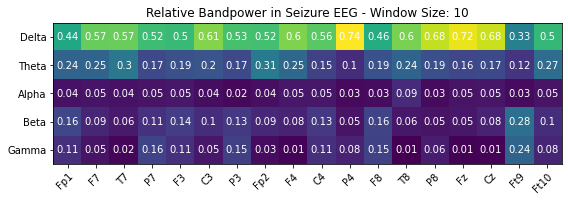

In [55]:
start, end = 3599-10, 3599
print(start, end)
raw = raw_clips[2].copy()
raw.crop(tmin=start, tmax=end, include_tmax=True)
raw.plot(**plot_kwargs);

# determine the dominant brain wave in all channels from seizure period
window_size = 10
sampling_freq = raw.info['sfreq']
eeg_channel_indices = mne.pick_types(raw.info, meg=False, eeg=True)
eeg_data, times = raw[eeg_channel_indices, :]
print(eeg_data.shape)
df = yasa.bandpower(eeg_data, sampling_freq, win_sec=window_size, bands=selected_bands, bandpass=True,
                    ch_names=raw.info.ch_names, relative=True)

# visualise with a heatmap
channels = list(df.index)
bands = list(df.iloc[:,0:5].columns)
relative_bandpower = df.iloc[:,0:5].to_numpy()

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(relative_bandpower.T)
ax.set_yticks(np.arange(len(bands)))
ax.set_xticks(np.arange(len(channels)))
ax.set_yticklabels(bands)
ax.set_xticklabels(channels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# loop over data dimensions and create text annotations
for i in range(len(bands)):
    for j in range(len(channels)):
        text = ax.text(j, i, np.around(relative_bandpower[j, i], 2), ha='center', va='center', color='w')

ax.set_title(f'Relative Bandpower in Seizure EEG - Window Size: {window_size}')
fig.tight_layout()
plt.show()

Next hour...

0 10


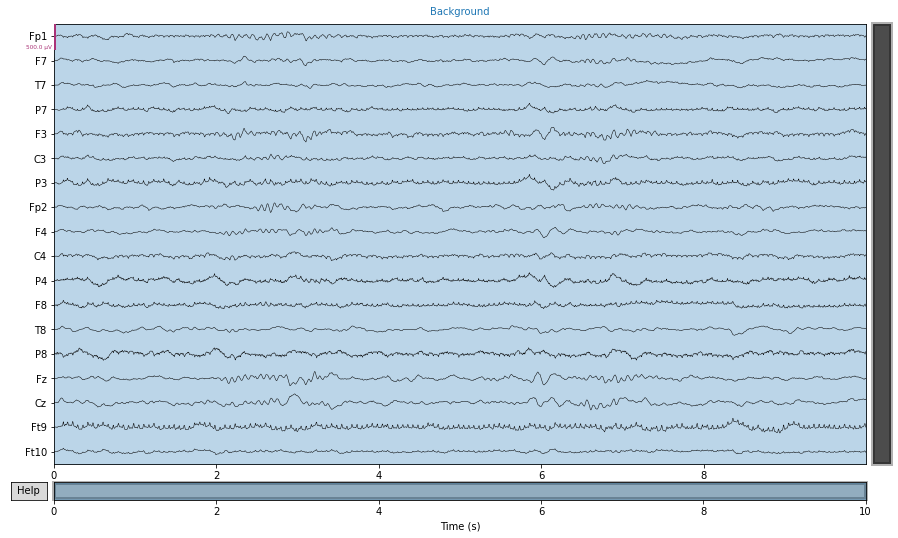

(18, 2561)


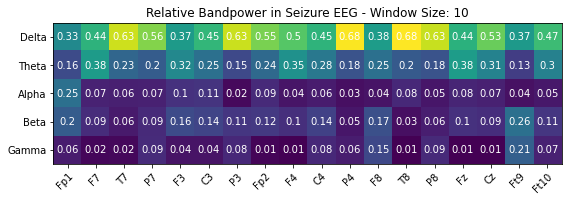

In [62]:
# crop 10s period from the start of the clip
start, end = 0, 10
print(start, end)
raw = raw_clips[3].copy()
raw.crop(tmin=start, tmax=end, include_tmax=True)
raw.plot(**plot_kwargs);

# determine the dominant brain wave in all channels from seizure period
window_size = 10
sampling_freq = raw.info['sfreq']
eeg_channel_indices = mne.pick_types(raw.info, meg=False, eeg=True)
eeg_data, times = raw[eeg_channel_indices, :]
print(eeg_data.shape)
df = yasa.bandpower(eeg_data, sampling_freq, win_sec=window_size, bands=selected_bands, bandpass=True,
                    ch_names=raw.info.ch_names, relative=True)

# visualise with a heatmap
channels = list(df.index)
bands = list(df.iloc[:,0:5].columns)
relative_bandpower = df.iloc[:,0:5].to_numpy()

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(relative_bandpower.T)
ax.set_yticks(np.arange(len(bands)))
ax.set_xticks(np.arange(len(channels)))
ax.set_yticklabels(bands)
ax.set_xticklabels(channels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# loop over data dimensions and create text annotations
for i in range(len(bands)):
    for j in range(len(channels)):
        text = ax.text(j, i, np.around(relative_bandpower[j, i], 2), ha='center', va='center', color='w')

ax.set_title(f'Relative Bandpower in Seizure EEG - Window Size: {window_size}')
fig.tight_layout()
plt.show()

10s pre seizure

1457 1467


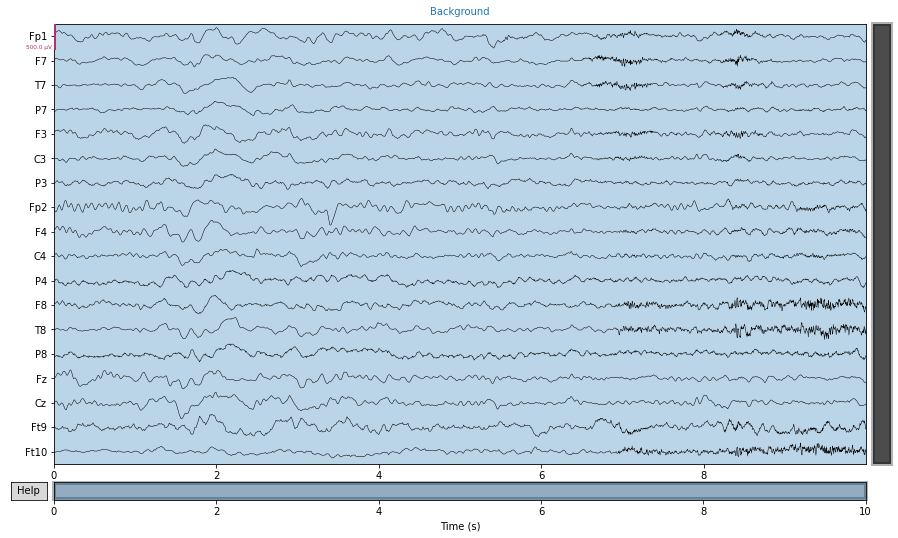

(18, 2561)


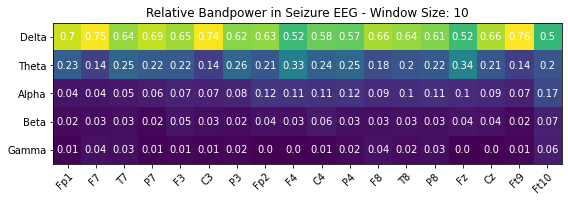

In [63]:
start, end = 1467-10, 1467
print(start, end)
raw = raw_clips[3].copy()
raw.crop(tmin=start, tmax=end, include_tmax=True)
raw.plot(**plot_kwargs);

# determine the dominant brain wave in all channels from seizure period
window_size = 10
sampling_freq = raw.info['sfreq']
eeg_channel_indices = mne.pick_types(raw.info, meg=False, eeg=True)
eeg_data, times = raw[eeg_channel_indices, :]
print(eeg_data.shape)
df = yasa.bandpower(eeg_data, sampling_freq, win_sec=window_size, bands=selected_bands, bandpass=True,
                    ch_names=raw.info.ch_names, relative=True)

# visualise with a heatmap
channels = list(df.index)
bands = list(df.iloc[:,0:5].columns)
relative_bandpower = df.iloc[:,0:5].to_numpy()

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(relative_bandpower.T)
ax.set_yticks(np.arange(len(bands)))
ax.set_xticks(np.arange(len(channels)))
ax.set_yticklabels(bands)
ax.set_xticklabels(channels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# loop over data dimensions and create text annotations
for i in range(len(bands)):
    for j in range(len(channels)):
        text = ax.text(j, i, np.around(relative_bandpower[j, i], 2), ha='center', va='center', color='w')

ax.set_title(f'Relative Bandpower in Seizure EEG - Window Size: {window_size}')
fig.tight_layout()
plt.show()

10s into seizure

1477 1487


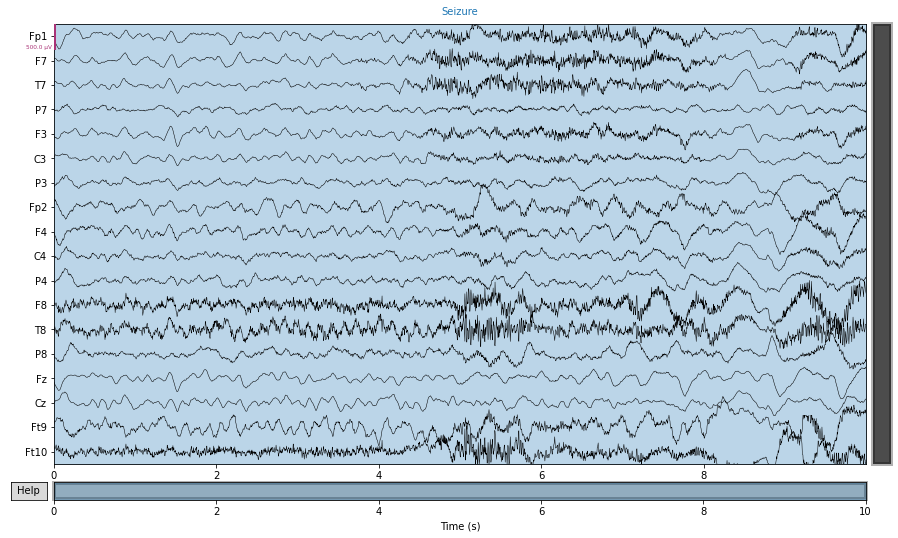

(18, 2561)


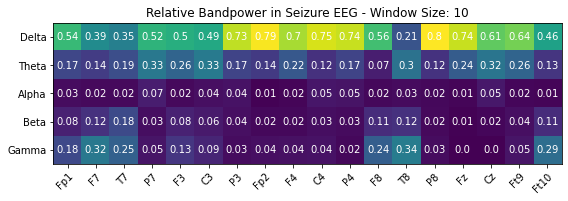

In [64]:
# crop 10s period from the start of the clip
start, end = 1467+10, 1467+20
print(start, end)
raw = raw_clips[3].copy()
raw.crop(tmin=start, tmax=end, include_tmax=True)
raw.plot(**plot_kwargs);

# determine the dominant brain wave in all channels from seizure period
window_size = 10
sampling_freq = raw.info['sfreq']
eeg_channel_indices = mne.pick_types(raw.info, meg=False, eeg=True)
eeg_data, times = raw[eeg_channel_indices, :]
print(eeg_data.shape)
df = yasa.bandpower(eeg_data, sampling_freq, win_sec=window_size, bands=selected_bands, bandpass=True,
                    ch_names=raw.info.ch_names, relative=True)

# visualise with a heatmap
channels = list(df.index)
bands = list(df.iloc[:,0:5].columns)
relative_bandpower = df.iloc[:,0:5].to_numpy()

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(relative_bandpower.T)
ax.set_yticks(np.arange(len(bands)))
ax.set_xticks(np.arange(len(channels)))
ax.set_yticklabels(bands)
ax.set_xticklabels(channels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# loop over data dimensions and create text annotations
for i in range(len(bands)):
    for j in range(len(channels)):
        text = ax.text(j, i, np.around(relative_bandpower[j, i], 2), ha='center', va='center', color='w')

ax.set_title(f'Relative Bandpower in Seizure EEG - Window Size: {window_size}')
fig.tight_layout()
plt.show()

10s before end of seizure.

1480 1490


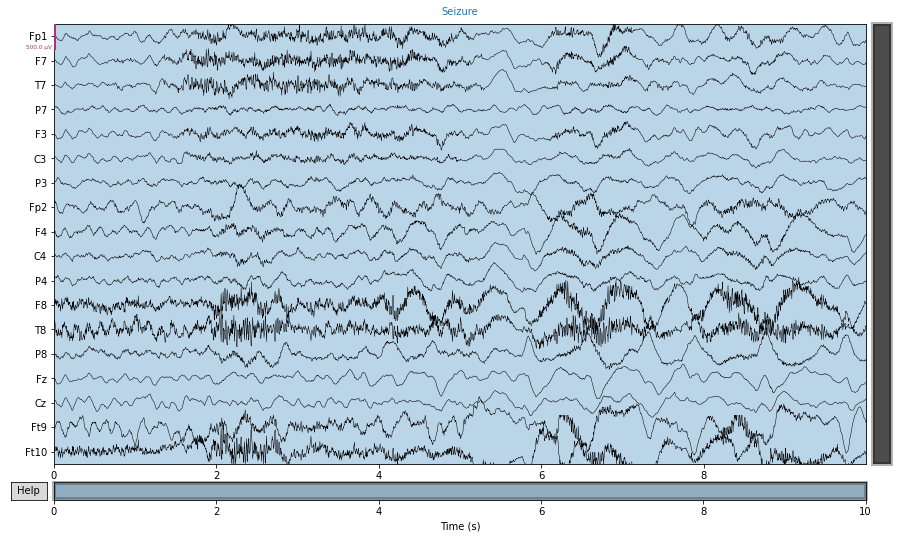

(18, 2561)


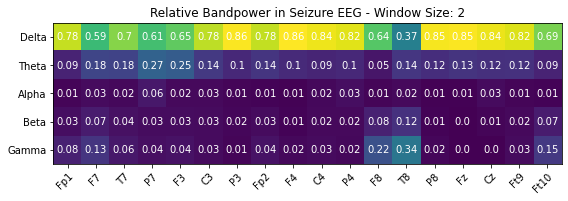

In [67]:
start, end = 1490-10, 1490
print(start, end)
raw = raw_clips[3].copy()
raw.crop(tmin=start, tmax=end, include_tmax=True)
raw.plot(**plot_kwargs);

# determine the dominant brain wave in all channels from seizure period
window_size = 2
sampling_freq = raw.info['sfreq']
eeg_channel_indices = mne.pick_types(raw.info, meg=False, eeg=True)
eeg_data, times = raw[eeg_channel_indices, :]
print(eeg_data.shape)
df = yasa.bandpower(eeg_data, sampling_freq, win_sec=window_size, bands=selected_bands, bandpass=True,
                    ch_names=raw.info.ch_names, relative=True)

# visualise with a heatmap
channels = list(df.index)
bands = list(df.iloc[:,0:5].columns)
relative_bandpower = df.iloc[:,0:5].to_numpy()

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(relative_bandpower.T)
ax.set_yticks(np.arange(len(bands)))
ax.set_xticks(np.arange(len(channels)))
ax.set_yticklabels(bands)
ax.set_xticklabels(channels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# loop over data dimensions and create text annotations
for i in range(len(bands)):
    for j in range(len(channels)):
        text = ax.text(j, i, np.around(relative_bandpower[j, i], 2), ha='center', va='center', color='w')

ax.set_title(f'Relative Bandpower in Seizure EEG - Window Size: {window_size}')
fig.tight_layout()
plt.show()

1457 1467


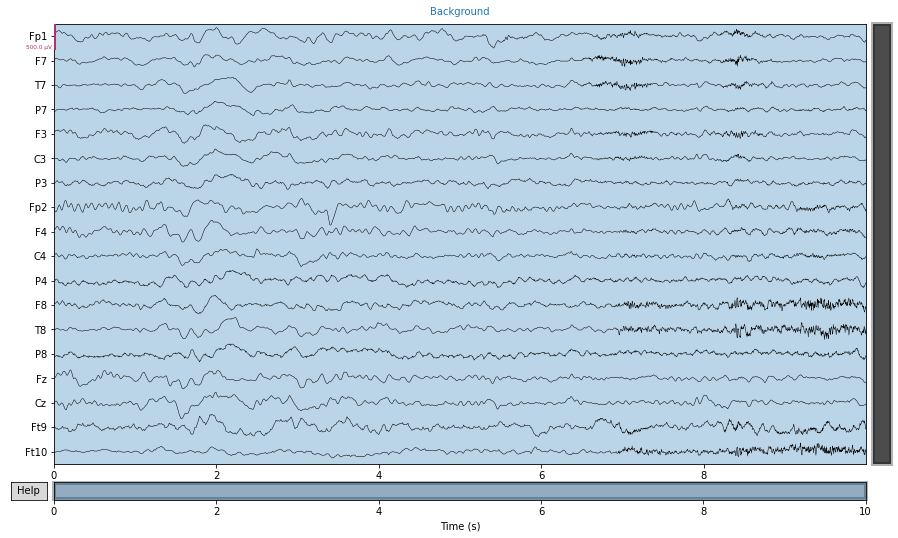

(18, 2561)


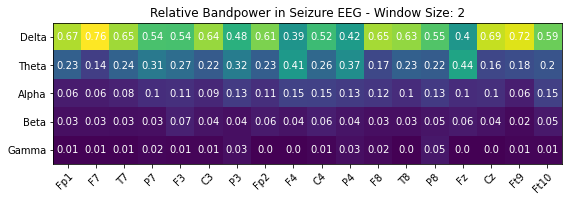

In [66]:
# crop 10s period before end of seizure
start, end = 1467-10, 1467
print(start, end)
raw = raw_clips[3].copy()
raw.crop(tmin=start, tmax=end, include_tmax=True)
raw.plot(**plot_kwargs);

# determine the dominant brain wave in all channels from seizure period
window_size = 2
sampling_freq = raw.info['sfreq']
eeg_channel_indices = mne.pick_types(raw.info, meg=False, eeg=True)
eeg_data, times = raw[eeg_channel_indices, :]
print(eeg_data.shape)
df = yasa.bandpower(eeg_data, sampling_freq, win_sec=window_size, bands=selected_bands, bandpass=True,
                    ch_names=raw.info.ch_names, relative=True)

# visualise with a heatmap
channels = list(df.index)
bands = list(df.iloc[:,0:5].columns)
relative_bandpower = df.iloc[:,0:5].to_numpy()

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(relative_bandpower.T)
ax.set_yticks(np.arange(len(bands)))
ax.set_xticks(np.arange(len(channels)))
ax.set_yticklabels(bands)
ax.set_xticklabels(channels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# loop over data dimensions and create text annotations
for i in range(len(bands)):
    for j in range(len(channels)):
        text = ax.text(j, i, np.around(relative_bandpower[j, i], 2), ha='center', va='center', color='w')

ax.set_title(f'Relative Bandpower in Seizure EEG - Window Size: {window_size}')
fig.tight_layout()
plt.show()

In [ ]:
fp1_fs = raw_clips[2].info['sfreq']
fp1_sig, fp1_times = raw_clips[2][0, :]
print(fp1_fs)
print(fp1_sig.shape)
print(fp1_times.shape)

## Spectrograms

In [ ]:
# file: chb_01_03 containing 1 seizure around 0.8 hrs
fs = raw_clips[2].info['sfreq']
for i in range(len(raw_clips[2].info['ch_names'])):
    sig, _ = raw_clips[2][i,:]
    fig = yasa.plot_spectrogram(sig.reshape(-1,), fs, fmin=0.1, fmax=127.9)
    plt.title(f"{raw_clips[2].info['ch_names'][i]}")
    fig.tight_layout()
    plt.show()

In [ ]:
# file: chb_01_04 containing 1 seizure
fs = raw_clips[3].info['sfreq']
for i in range(len(raw_clips[3].info['ch_names'])):
    sig, _ = raw_clips[3][i,:]
    fig = yasa.plot_spectrogram(sig.reshape(-1,), fs, fmin=0.1, fmax=127.9)
    plt.title(f"{raw_clips[2].info['ch_names'][i]}")
    fig.tight_layout()
    plt.show()

In [ ]:
# plot spectrogram for channel Fp1
fig = yasa.plot_spectrogram(fp1_sig.reshape(-1,), fp1_fs, fmin=0.1, fmax=(fp1_fs/2)-1)
fig.tight_layout()
fig.show()

In [ ]:
# plot spectrogram for channel Fp1 (beta band)
fig = yasa.plot_spectrogram(fp1_sig.reshape(-1,), fp1_fs, fmin=12, fmax=30)
plt.title(r'$\beta$: 12 - 30 Hz')
fig.tight_layout()
fig.show()

It was concluded that the optimum method to perform the real-time spectral estimation of beta band from MER signal is Welch with Hamming windows of 1.5 seconds and 50% overlap.

https://www.hindawi.com/journals/cin/2017/1512504/